In [2]:
import cv2
import glob
import numpy as np
print("OpenCV version :  {0}".format(cv2.__version__))

OpenCV version :  3.4.2


# Step 1 Load the image pair and camera parameters.

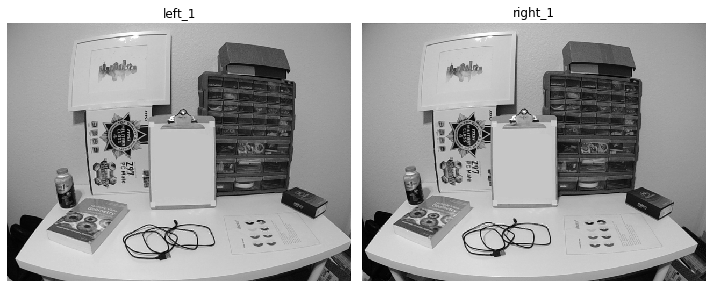

In [4]:
# 0 for grayscale
left_ = [cv2.imread(image, 0) for image in sorted(glob.glob("../../images/task_7/left_*.png"))]
right_ = [cv2.imread(image, 0) for image in sorted(glob.glob("../../images/task_7/right_*.png"))]

import matplotlib.pyplot as plt
def plot_figures(figures, nrows=1, ncols=1):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10,10))
    if(nrows > 1 or ncols > 1):
        for ind,title in enumerate(figures):
            axeslist.ravel()[ind].imshow(figures[title], cmap=plt.gray())
            axeslist.ravel()[ind].set_title(title)
            axeslist.ravel()[ind].set_axis_off()
        plt.tight_layout() # optional
    else:
        for ind,title in enumerate(figures):
            axeslist.imshow(figures[title], cmap=plt.gray())
            axeslist.set_title(title)
            axeslist.set_axis_off()
            

plot_figures({'left_1': left_[0], 'right_1': right_[0]}, 1, 2)

s = cv2.FileStorage('../../parameters/left_camera_intrinsics.xml', cv2.FileStorage_READ)

mtx_left = s.getNode('mtx_left').mat()
distCoeffs_left = s.getNode('distCoeffs_left').mat()
s.release()


s = cv2.FileStorage('../../parameters/right_camera_intrinsics.xml', cv2.FileStorage_READ)

mtx_right = s.getNode('mtx_right').mat()
distCoeffs_right = s.getNode('distCoeffs_right').mat()
s.release()


s = cv2.FileStorage('../../parameters/stereo_calibration.xml', cv2.FileStorage_READ)
R = s.getNode('R').mat()
T = s.getNode('T').mat()
E = s.getNode('E').mat()
F = s.getNode('F').mat()


s = cv2.FileStorage('../../parameters/stereo_rectification.xml', cv2.FileStorage_READ)
R1 = s.getNode('R1').mat()
R2 = s.getNode('R2').mat()
P1 = s.getNode('P1').mat()
P2 = s.getNode('P2').mat()
Q = s.getNode('Q').mat()
roi1 = s.getNode('roi1').mat()
roi2 = s.getNode('roi2').mat()

# Step 2 Detect, match, and associate features on the image pair.

In [6]:
img_left = left_[0].copy()
img_right = right_[0].copy()

# Initiate STAR detector
orb = cv2.ORB_create()

# find the keypoints with ORB
kp_left = orb.detect(img_left,None)
kp_right = orb.detect(img_right,None)

# compute the descriptors with ORB
kp_left, des_left = orb.compute(img_left, kp_left)
kp_right, des_right = orb.compute(img_right, kp_right)

In [7]:
import math
def euclidean_dist(pt1, pt2):
    return math.sqrt((pt2[0]-pt1[0])**2 + (pt2[1]-pt1[1])**2)

def filter_kp(kp, distance=8):
    l = []

    for i in range(len(kp)-2):
        for j in range(i+1,len(kp)-2):
            if euclidean_dist(kp[i].pt,kp[j].pt) < distance:
                # keep the point with the higher response value
                if kp[i].response > kp[j].response:
                    l.append(j)
                else:
                    l.append(i)
                    j = len(kp)

    l = list(dict.fromkeys(l))
    l = sorted(l, reverse=True)
#     print('l: ', l)
    # remove items
    for i in l:
        kp.pop(i)
    
    return kp

In [16]:
len(kp_right)
#print(kp_right)

500

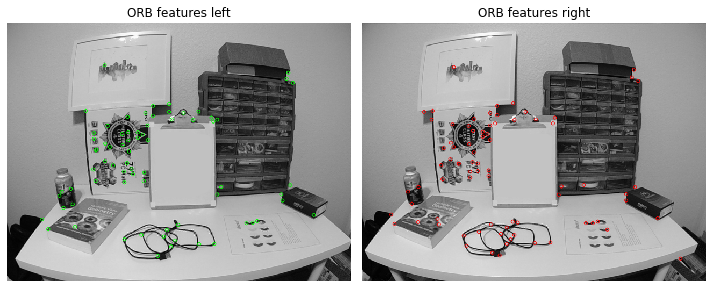

In [9]:
kp_left_filtered = filter_kp(kp_left.copy())
kp_right_filtered = filter_kp(kp_right.copy())


img_left_pts = cv2.drawKeypoints(img_left.copy(), kp_left_filtered, outImage = None, color=(0,255,0))
img_right_pts = cv2.drawKeypoints(img_right.copy(), kp_right_filtered, outImage = None, color=(255,0,0))

plot_figures({'ORB features left':img_left_pts, 'ORB features right':img_right_pts},1,2)

In [112]:
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des_left,des_right)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

In [113]:
print(des_left)

[[ 75 179 242 ... 166 207 255]
 [171  23 126 ... 172 206 215]
 [107  50 235 ... 140  30  95]
 ...
 [198 182 254 ... 192 173 119]
 [255 251  96 ... 183  74 125]
 [186 221 111 ...  62 118 255]]


In [28]:
print(kp_left_filtered)

[<KeyPoint 0x7f407b757ed0>, <KeyPoint 0x7f407b757f90>, <KeyPoint 0x7f407b757fc0>, <KeyPoint 0x7f407b758030>, <KeyPoint 0x7f407b758060>, <KeyPoint 0x7f407b758090>, <KeyPoint 0x7f407b7580f0>, <KeyPoint 0x7f407b758120>, <KeyPoint 0x7f407b758150>, <KeyPoint 0x7f407b758270>, <KeyPoint 0x7f407b758300>, <KeyPoint 0x7f407b758360>, <KeyPoint 0x7f407b7583f0>, <KeyPoint 0x7f407b7584b0>, <KeyPoint 0x7f407b7584e0>, <KeyPoint 0x7f407b7585a0>, <KeyPoint 0x7f407b7586c0>, <KeyPoint 0x7f407b7587b0>, <KeyPoint 0x7f407b758810>, <KeyPoint 0x7f407b7588d0>, <KeyPoint 0x7f407b758900>, <KeyPoint 0x7f407b758960>, <KeyPoint 0x7f407b758a80>, <KeyPoint 0x7f407b758ab0>, <KeyPoint 0x7f407b758ba0>, <KeyPoint 0x7f407b758bd0>, <KeyPoint 0x7f407b758c00>, <KeyPoint 0x7f407b758c30>, <KeyPoint 0x7f407b758d20>, <KeyPoint 0x7f407b758ed0>, <KeyPoint 0x7f407b758f90>, <KeyPoint 0x7f407b759240>, <KeyPoint 0x7f407b7592a0>, <KeyPoint 0x7f407b759360>, <KeyPoint 0x7f407b759810>, <KeyPoint 0x7f407b759900>, <KeyPoint 0x7f407b759a20>, 

In [63]:
print(matches)

[<DMatch 0x7f407b6892b0>, <DMatch 0x7f407b684e70>, <DMatch 0x7f407b684690>, <DMatch 0x7f407b6892d0>, <DMatch 0x7f407b689890>, <DMatch 0x7f407b684790>, <DMatch 0x7f407b684b50>, <DMatch 0x7f407b684d70>, <DMatch 0x7f407b687810>, <DMatch 0x7f407b6895d0>, <DMatch 0x7f407b684fb0>, <DMatch 0x7f407b6871b0>, <DMatch 0x7f407b6879d0>, <DMatch 0x7f407b689910>, <DMatch 0x7f407b6846d0>, <DMatch 0x7f407b684a10>, <DMatch 0x7f407b6874f0>, <DMatch 0x7f407b6890b0>, <DMatch 0x7f407b684070>, <DMatch 0x7f407b684210>, <DMatch 0x7f407b684410>, <DMatch 0x7f407b687eb0>, <DMatch 0x7f407b6ca570>, <DMatch 0x7f407b6cacf0>, <DMatch 0x7f407b687a30>, <DMatch 0x7f407b687ab0>, <DMatch 0x7f407b687e90>, <DMatch 0x7f407b689430>, <DMatch 0x7f407b6895b0>, <DMatch 0x7f407b689930>, <DMatch 0x7f407b684030>, <DMatch 0x7f407b684950>, <DMatch 0x7f407b6870d0>, <DMatch 0x7f407b687910>, <DMatch 0x7f407b687c50>, <DMatch 0x7f407b687c70>, <DMatch 0x7f407b689270>, <DMatch 0x7f407b689490>, <DMatch 0x7f407b684350>, <DMatch 0x7f407b6847b0>,

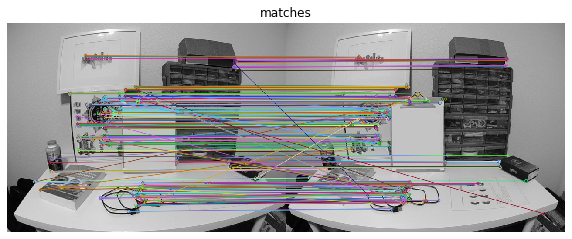

In [12]:
# img_left = left_[0].copy()
# img_right = right_[0].copy()
img3 = cv2.drawMatches(img_left,kp_left,img_right,kp_right,matches[:], None,flags=2)

plot_figures({'matches':img3})

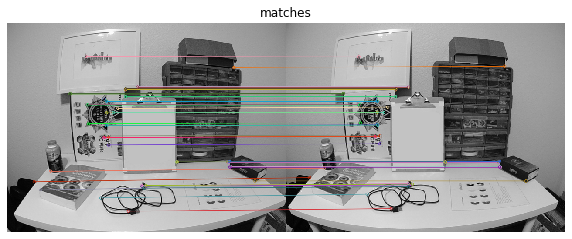

In [13]:
# Draw first 50 matches.
img3 = cv2.drawMatches(img_left,kp_left,img_right,kp_right,matches[:50], None,flags=2)

plot_figures({'matches':img3})

In [24]:
print(matches[0])

<DMatch 0x7f407b6892b0>


# Step 3 Calculate the essential matrix between the image pair.

In [115]:
# select points to evaluate the fundamental matrix
pts1 = []
pts2 = []
idx = matches[1:20]

for i in idx:
    pts1.append(kp_left[i.queryIdx].pt)
    pts2.append(kp_right[i.trainIdx].pt)

pts1 = np.array(pts1)
pts2 = np.array(pts2)

# creating homegeneous coordenate
pones = np.ones((1, len(pts1))).T

pth_1 = np.hstack((pts1, pones))
pth_2 = np.hstack((pts2, pones))

In [117]:
# evaluate the essential Matrix (using the original points, not the normilized ones)
E, mask0 = cv2.findEssentialMat(pts1, pts2)
# evaluate the fundamental matrix (using the normilized points)
F, mask = cv2.findFundamentalMat(pts1, pts2)

E = np.mat(E)
F = np.mat(F)

In [118]:
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

In [126]:
print(pts1)

[[227.52000427 236.16000366]
 [310.80001831 375.6000061 ]
 [507.61740112 320.99334717]
 [505.2286377  318.90319824]
 [271.20001221 153.6000061 ]
 [181.20001221  78.        ]
 [277.92001343 432.00003052]
 [309.31204224 374.9760437 ]
 [185.13105774 188.11703491]
 [509.76000977 318.24002075]
 [271.64163208 153.44642639]
 [390.5668335  318.90319824]
 [226.80000305 180.        ]
 [222.00001526 264.        ]
 [ 62.20800781 364.60803223]
 [ 77.13793945 383.2013855 ]
 [223.         260.        ]
 [301.         150.        ]]


In [124]:
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img_left, img_right, lines1, pts1, pts2)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img_right, img_left, lines2, pts2, pts1)

In [123]:
def drawlines(img1, img2, lines, pts1, pts2):
    """ img1 - image on which we draw the epilines for the points in img2
    lines - corresponding epilines """
    r, c = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1]])
        img1 = cv2.line(img1, (x0, y0), (x1, y1), color, 1)
    return img1, img2

(<matplotlib.axes._subplots.AxesSubplot at 0x7f407813ebd0>,
 <matplotlib.image.AxesImage at 0x7f40781cf590>)

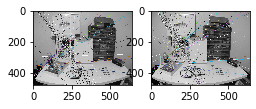

In [125]:
plt.subplot(131), plt.imshow(img5)
plt.subplot(132), plt.imshow(img3)